대한민국 코로나 누적 확진자 수 데이터를 불러온 후, 데이터를 훈련용, 검증용, 시험용으로 나눈 뒤 LSTM 모델을 통해 코로나 확진자 수를 예측

In [41]:
import torch
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
from torch import nn, optim

## notebook을 실행한 브라우저에서 바로 그림을 보게 해줌
%matplotlib inline

## 그래프의 해상도를 높여줌
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
rcParams['figure.figsize'] = 14, 10
register_matplotlib_converters()

## random_seed값을 고정시켜주어, 매 실험마다 같은 세팅(같은 난수를 생성하도록)으로 진행
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [42]:
!git clone https://github.com/Pseudo-Lab/Tutorial-Book-Utils
!python Tutorial-Book-Utils/PL_data_loader.py --data COVIDTimeSeries
!unzip -q COVIDTimeSeries.zip

fatal: destination path 'Tutorial-Book-Utils' already exists and is not an empty directory.
Downloading...
From: https://drive.google.com/uc?id=1B36Djko-f0LtVxSaBEVYosLTTsu0qtsh
To: /content/COVIDTimeSeries.zip
100% 3.18M/3.18M [00:00<00:00, 16.6MB/s]
COVIDTimeSeries.zip download complete!
replace covid_19_data.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [69]:
#대한민국 데이터만 추출 후 일자별 확진자 수로 변환
confirmed = pd.read_csv('time_series_covid19_confirmed_global.csv')
confirmed[confirmed['Country/Region']=='Korea, South']
korea = confirmed[confirmed['Country/Region']=='Korea, South'].iloc[:,4:].T
korea.index = pd.to_datetime(korea.index)
daily_cases = korea.diff().fillna(korea.iloc[0]).astype('int')


def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data)-seq_length):
        x = data.iloc[i:(i+seq_length)]
        y = data.iloc[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

#지도학습용 데이터로 변환
seq_length = 5
X, y = create_sequences(daily_cases, seq_length)

#학습용, 검증용, 시험용으로 분리
train_size = int(327 * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size+33], y[train_size:train_size+33]
X_test, y_test = X[train_size+33:], y[train_size+33:]

######################## Todo: X_train 의 min값과 max 값으로 각 train, val, test셋을 모두 MinMax 스케일링 ########################
#min-max scaling: 이상값에 민감, 분류 모델보다 회귀 모델에 적합하며 주로 이미지 처리에 사용, dataset의 범위를 0~1로 변환

print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_val:", X_val.shape)
print("y_val:", y_val.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

mMscaler = MinMaxScaler()
mMscaler.fit(X_train.reshape(-1, 1)) #MinMaxScaler는 2 이하의 차원에 대해서만 fit 가능
#reshape에서 -1은 차원을 자동 결정하라는 것.

X_train = mMscaler.transform(X_train.reshape(-1, 1)).reshape(X_train.shape)
y_train = mMscaler.transform(y_train.reshape(-1, 1)).reshape(y_train.shape)
X_val = mMscaler.transform(X_val.reshape(-1, 1)).reshape(X_val.shape)
y_val = mMscaler.transform(y_val.reshape(-1, 1)).reshape(y_val.shape)
X_test = mMscaler.transform(X_test.reshape(-1, 1)).reshape(X_test.shape)
y_test = mMscaler.transform(y_test.reshape(-1, 1)).reshape(y_test.shape)

#Tensor 형태로 변환
def make_Tensor(array):
    return torch.from_numpy(array).float()

X_train = make_Tensor(X_train)
y_train = make_Tensor(y_train)
X_val = make_Tensor(X_val)
y_val = make_Tensor(y_val)
X_test = make_Tensor(X_test)
y_test = make_Tensor(y_test)

X_train: (261, 5, 1)
y_train: (261, 1)
X_val: (33, 5, 1)
y_val: (33, 1)
X_test: (33, 5, 1)
y_test: (33, 1)


In [70]:
print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)


##### expected shape,
# torch.Size([261, 5, 1]) torch.Size([33, 5, 1]) torch.Size([33, 5, 1])
# torch.Size([261, 1]) torch.Size([33, 1]) torch.Size([33, 1])

torch.Size([261, 5, 1]) torch.Size([33, 5, 1]) torch.Size([33, 5, 1])
torch.Size([261, 1]) torch.Size([33, 1]) torch.Size([33, 1])


In [71]:
######################## Todo: 모델 선언 ########################
## model의 구조는 nn.lstm을 통과한 뒤 nn.linear 를 통과
## n_features, n_hidden, seq_len, n_layer의 의미를 파악하여 적절한 nn.LSTM 선언하기
## nn.linear의 output dim은 1

class OurModel(nn.Module):
    def __init__(self, n_features, n_hidden, seq_len, n_layers):
        super(OurModel, self).__init__()
        ## Todo: 필요한 parameter, layer 정의
        self.n_features = n_features
        self.n_hidden = n_hidden
        self.seq_len = seq_len
        self.n_layers = n_layers
        #parameter 선언이 빠지면 외부에서 사용 불가->train 시 문제 발생


        self.lstm = nn.LSTM(input_size = n_features, hidden_size = n_hidden, num_layers =  n_layers)
        self.fc = nn.Linear(n_hidden, 1)

    # seq 별 hidden state reset을 위한 함수
    def reset_hidden_state(self):
        self.hidden = (
            torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
            torch.zeros(self.n_layers, self.seq_len, self.n_hidden)
        )

    def forward(self, sequences):
        ## Todo: 선언한 모델 통과, nn.LSTM, nn.Linear 순으로 통과, activation function 필요 없음
        y_pred, self.hidden = self.lstm(sequences, self.hidden)
        y_pred = self.fc(y_pred)

        return y_pred

In [72]:
def train_model(model, train_data, train_labels, val_data=None, val_labels=None, num_epochs=100, verbose = 10, patience = 10):
    loss_fn = torch.nn.L1Loss()
    optimiser = torch.optim.Adam(model.parameters(), lr=0.0001)
    train_hist = []
    val_hist = []
    for t in range(num_epochs):

        epoch_loss = 0

        for idx, seq in enumerate(train_data):

            model.reset_hidden_state() # seq 별 hidden state reset

            ######################## Todo: train loss=forward->val_train과 유사
            seq = torch.unsqueeze(seq, 0) #차원 값이 1인 차원 제거
            y_pred = model(seq)
            loss = loss_fn(y_pred[0].float(), train_labels[idx])

            ######################## Todo: update weights=backward
            optimiser.zero_grad() #optim 초기화
            loss.backward() #backward 진행
            optimiser.step() #backward 결과에 맞게 weight update

            epoch_loss += loss.item()

        train_hist.append(epoch_loss / len(train_data))

        if val_data is not None:

            with torch.no_grad():

                val_loss = 0

                for val_idx, val_seq in enumerate(val_data):

                    model.reset_hidden_state() # seq 별로 hidden state 초기화

                    val_seq = torch.unsqueeze(val_seq, 0)
                    y_val_pred = model(val_seq)
                    val_step_loss = loss_fn(y_val_pred[0].float(), val_labels[val_idx])

                    val_loss += val_step_loss

            val_hist.append(val_loss / len(val_data)) # val hist에 추가

            ## verbose 번째 마다 loss 출력
            if t % verbose == 0:
                print(f'Epoch {t} train loss: {epoch_loss / len(train_data)} val loss: {val_loss / len(val_data)}')

            ## patience 번째 마다 early stopping 여부 확인
            if (t % patience == 0) & (t != 0):

                ## loss가 커졌다면 early stop
                if val_hist[t - patience] < val_hist[t] :

                    print('\n Early Stopping')

                    break

        elif t % verbose == 0:
            print(f'Epoch {t} train loss: {epoch_loss / len(train_data)}')


    return model, train_hist, val_hist

**Todo: Model 선언 후 학습, 여러 hyperparamter로 실험해보기**


In [73]:
model = OurModel(
    n_features=1,
    n_hidden=4,
    seq_len=seq_length,
    n_layers=1
)


In [74]:
model, train_hist, val_hist = train_model(
    model,
    X_train,
    y_train,
    X_val,
    y_val,
    num_epochs=100,
    verbose=10,
    patience=50
)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([5, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Epoch 0 train loss: 0.1360432449032435 val loss: 0.04843224212527275
Epoch 10 train loss: 0.0781895880399172 val loss: 0.06785295903682709
Epoch 20 train loss: 0.07337867502471918 val loss: 0.06394056975841522
Epoch 30 train loss: 0.0672309897863217 val loss: 0.05818197876214981
Epoch 40 train loss: 0.06009332634601385 val loss: 0.05195637792348862
Epoch 50 train loss: 0.052406366813706654 val loss: 0.04557235538959503
Epoch 60 train loss: 0.04678544415414362 val loss: 0.042001333087682724
Epoch 70 train loss: 0.04426652077189379 val loss: 0.04012482240796089
Epoch 80 train loss: 0.0430631551675684 val loss: 0.039303526282310486
Epoch 90 train loss: 0.042844926075335465 val loss: 0.038832809776067734


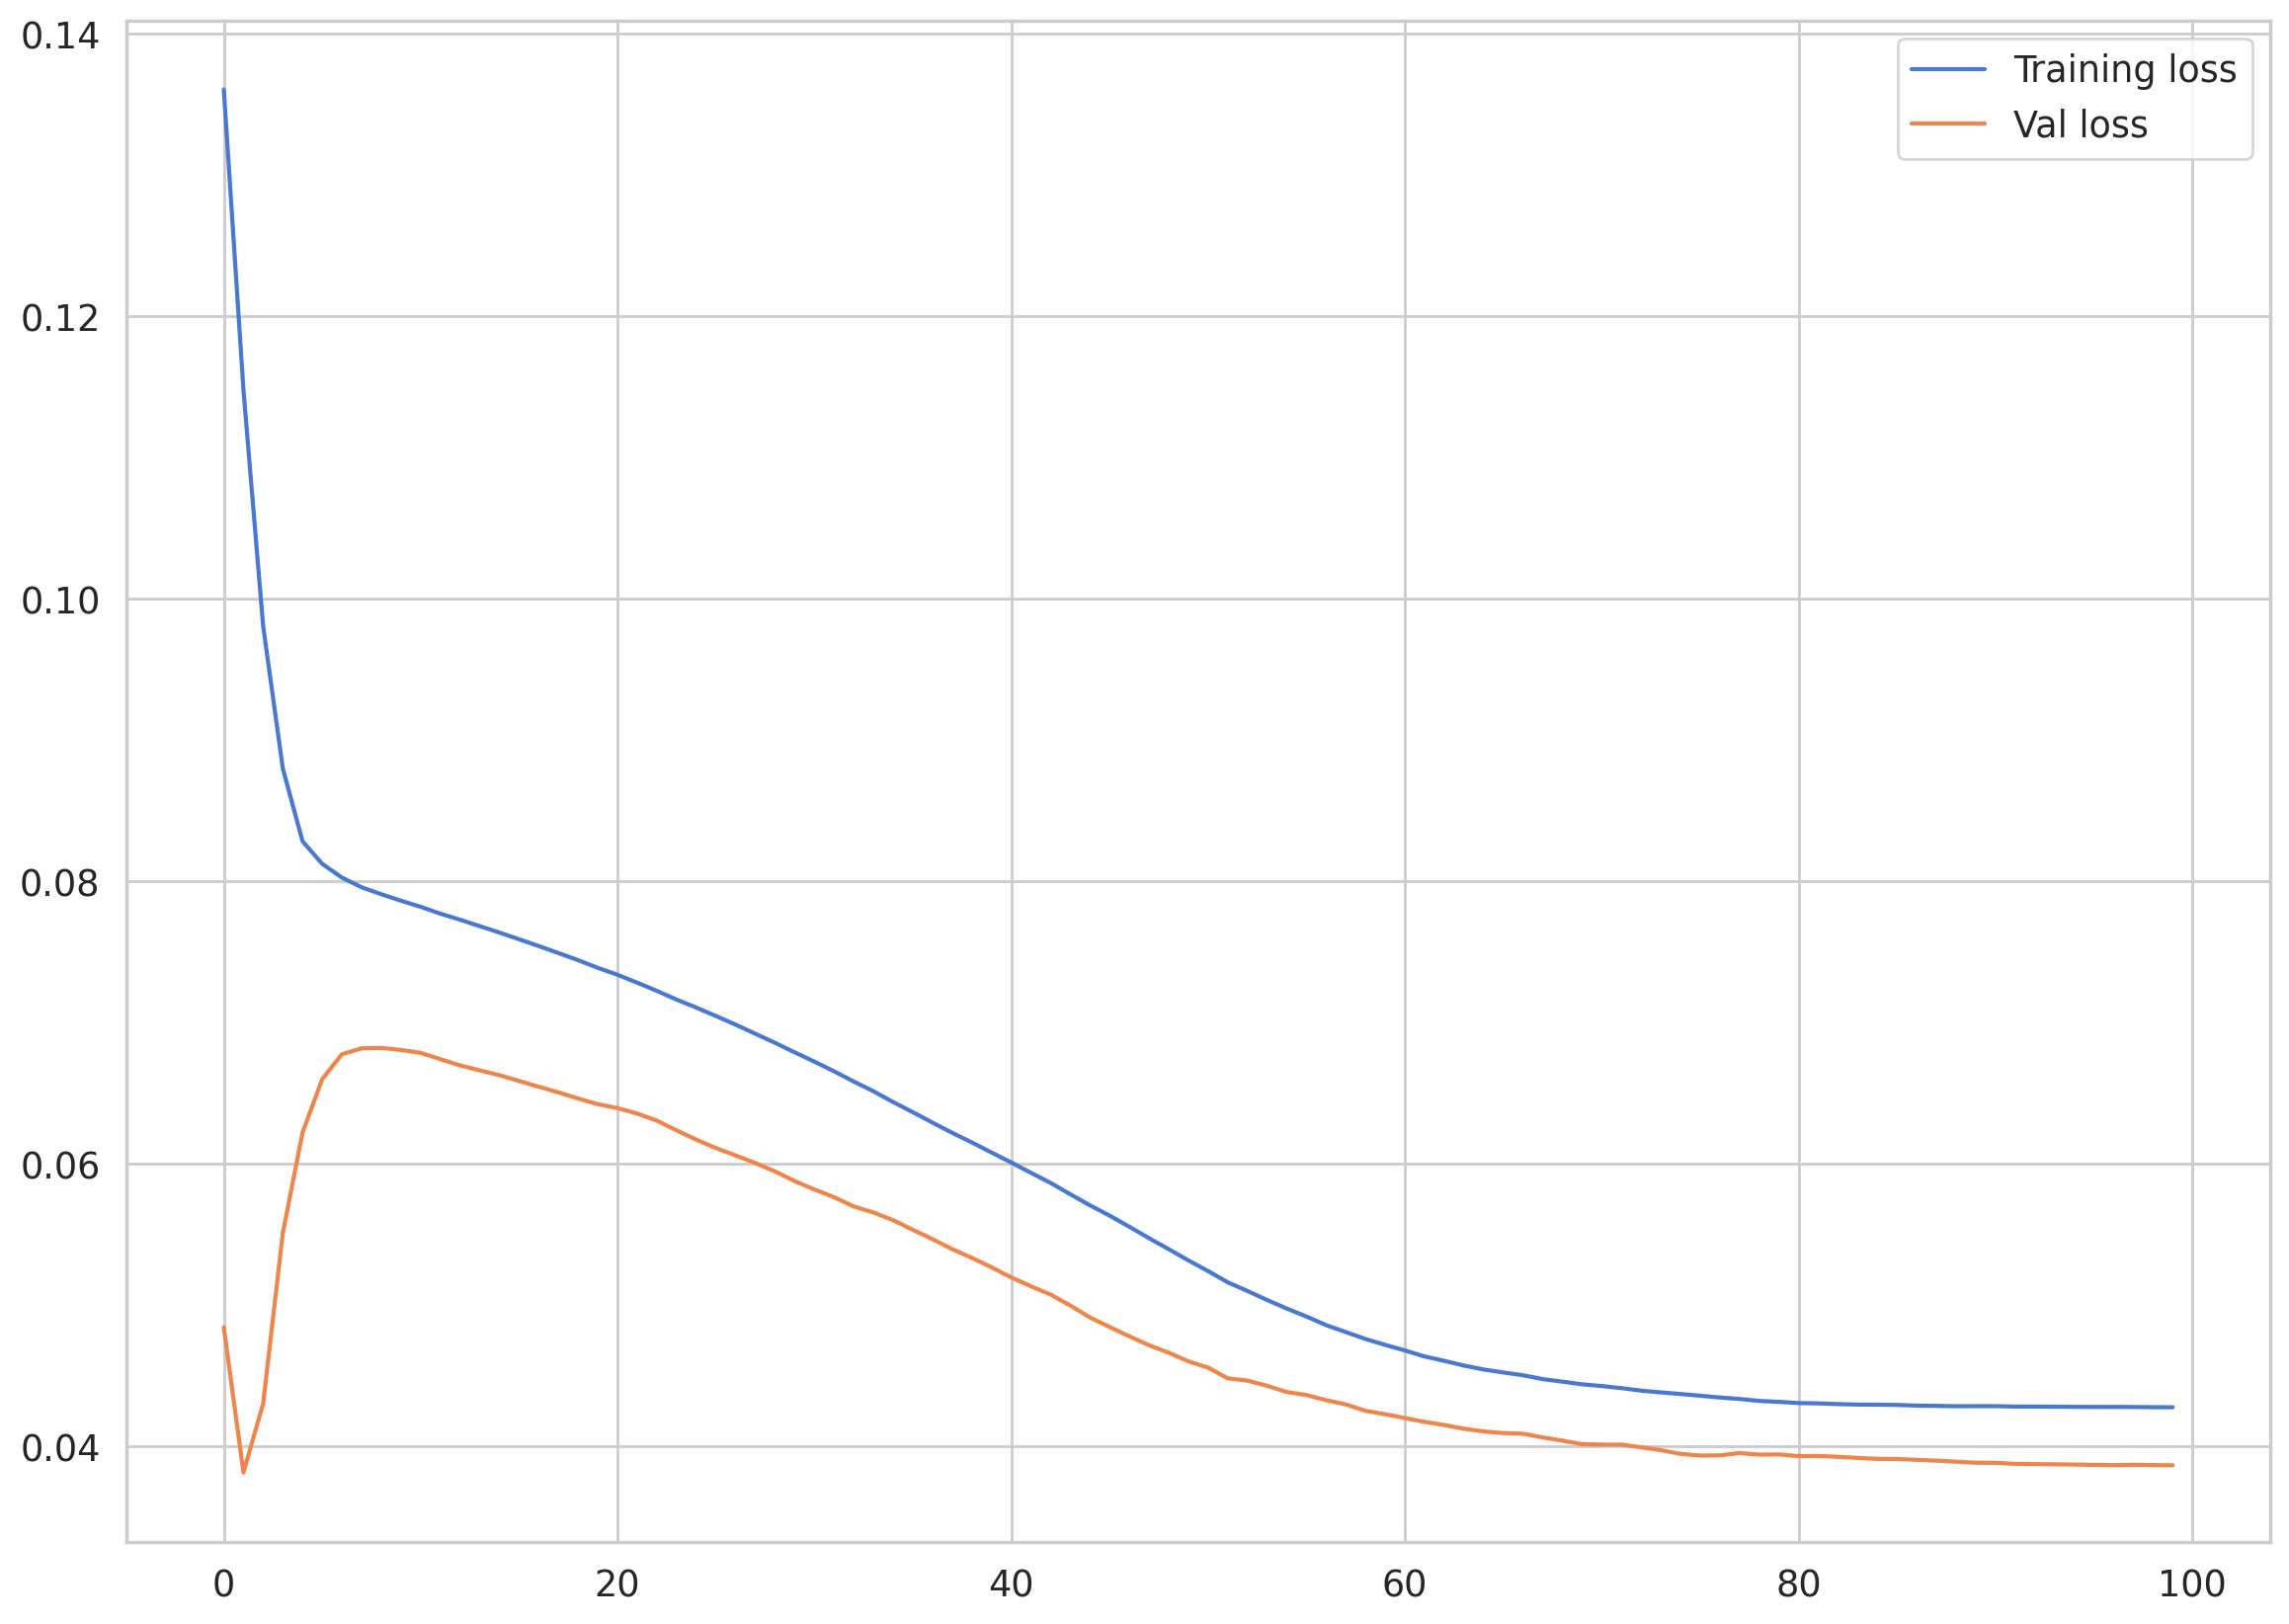

In [75]:
plt.plot(train_hist, label="Training loss")
plt.plot(val_hist, label="Val loss")
plt.legend()

***결과 예제***

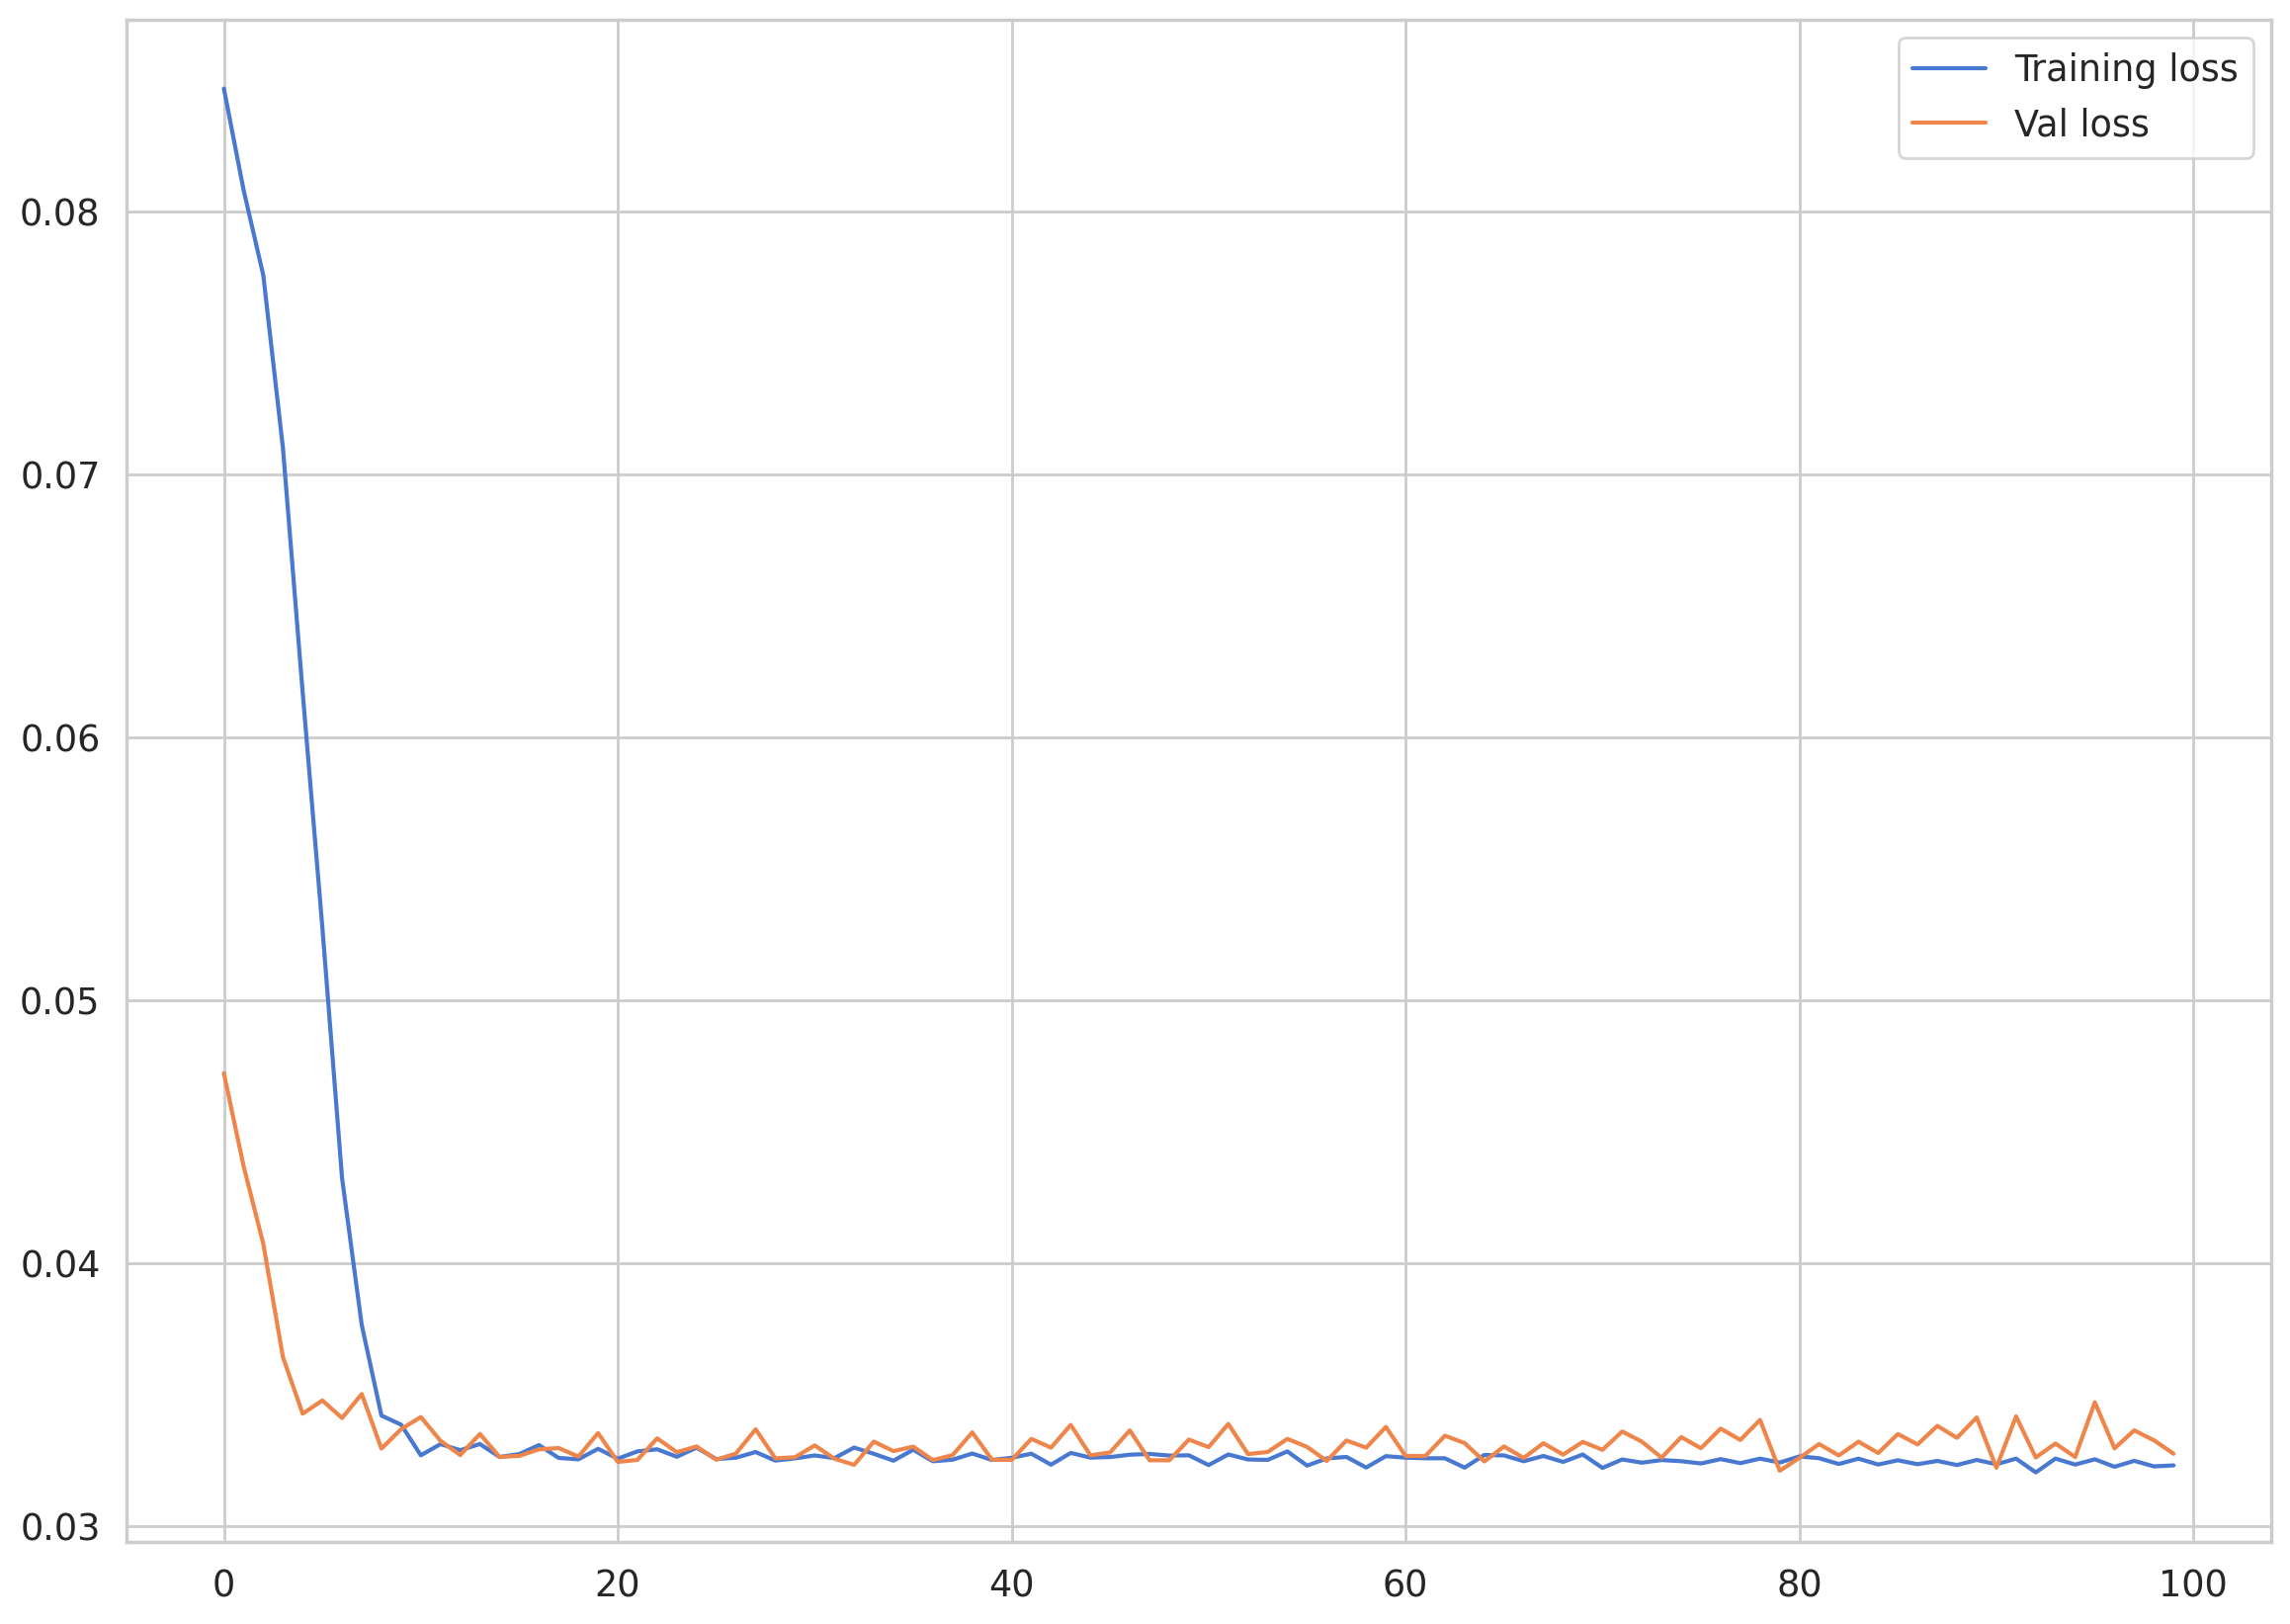

In [76]:
pred_dataset = X_test

with torch.no_grad():
    preds = []
    for _ in range(len(pred_dataset)):
        model.reset_hidden_state()
        y_test_pred = model(torch.unsqueeze(pred_dataset[_], 0))
        #pred = torch.flatten(y_test_pred).item()
        pred = y_test_pred[0, -1].item()
        preds.append(pred)

MinMax scaling 을 사용했기 때문에, output에 역으로 MinMax scaling 을 적용하여 y_test와 비교. 데이터셋에서 $x_{min}$ 이 0이었기 때문에 $x_{max}$값만 곱해주면 된다.

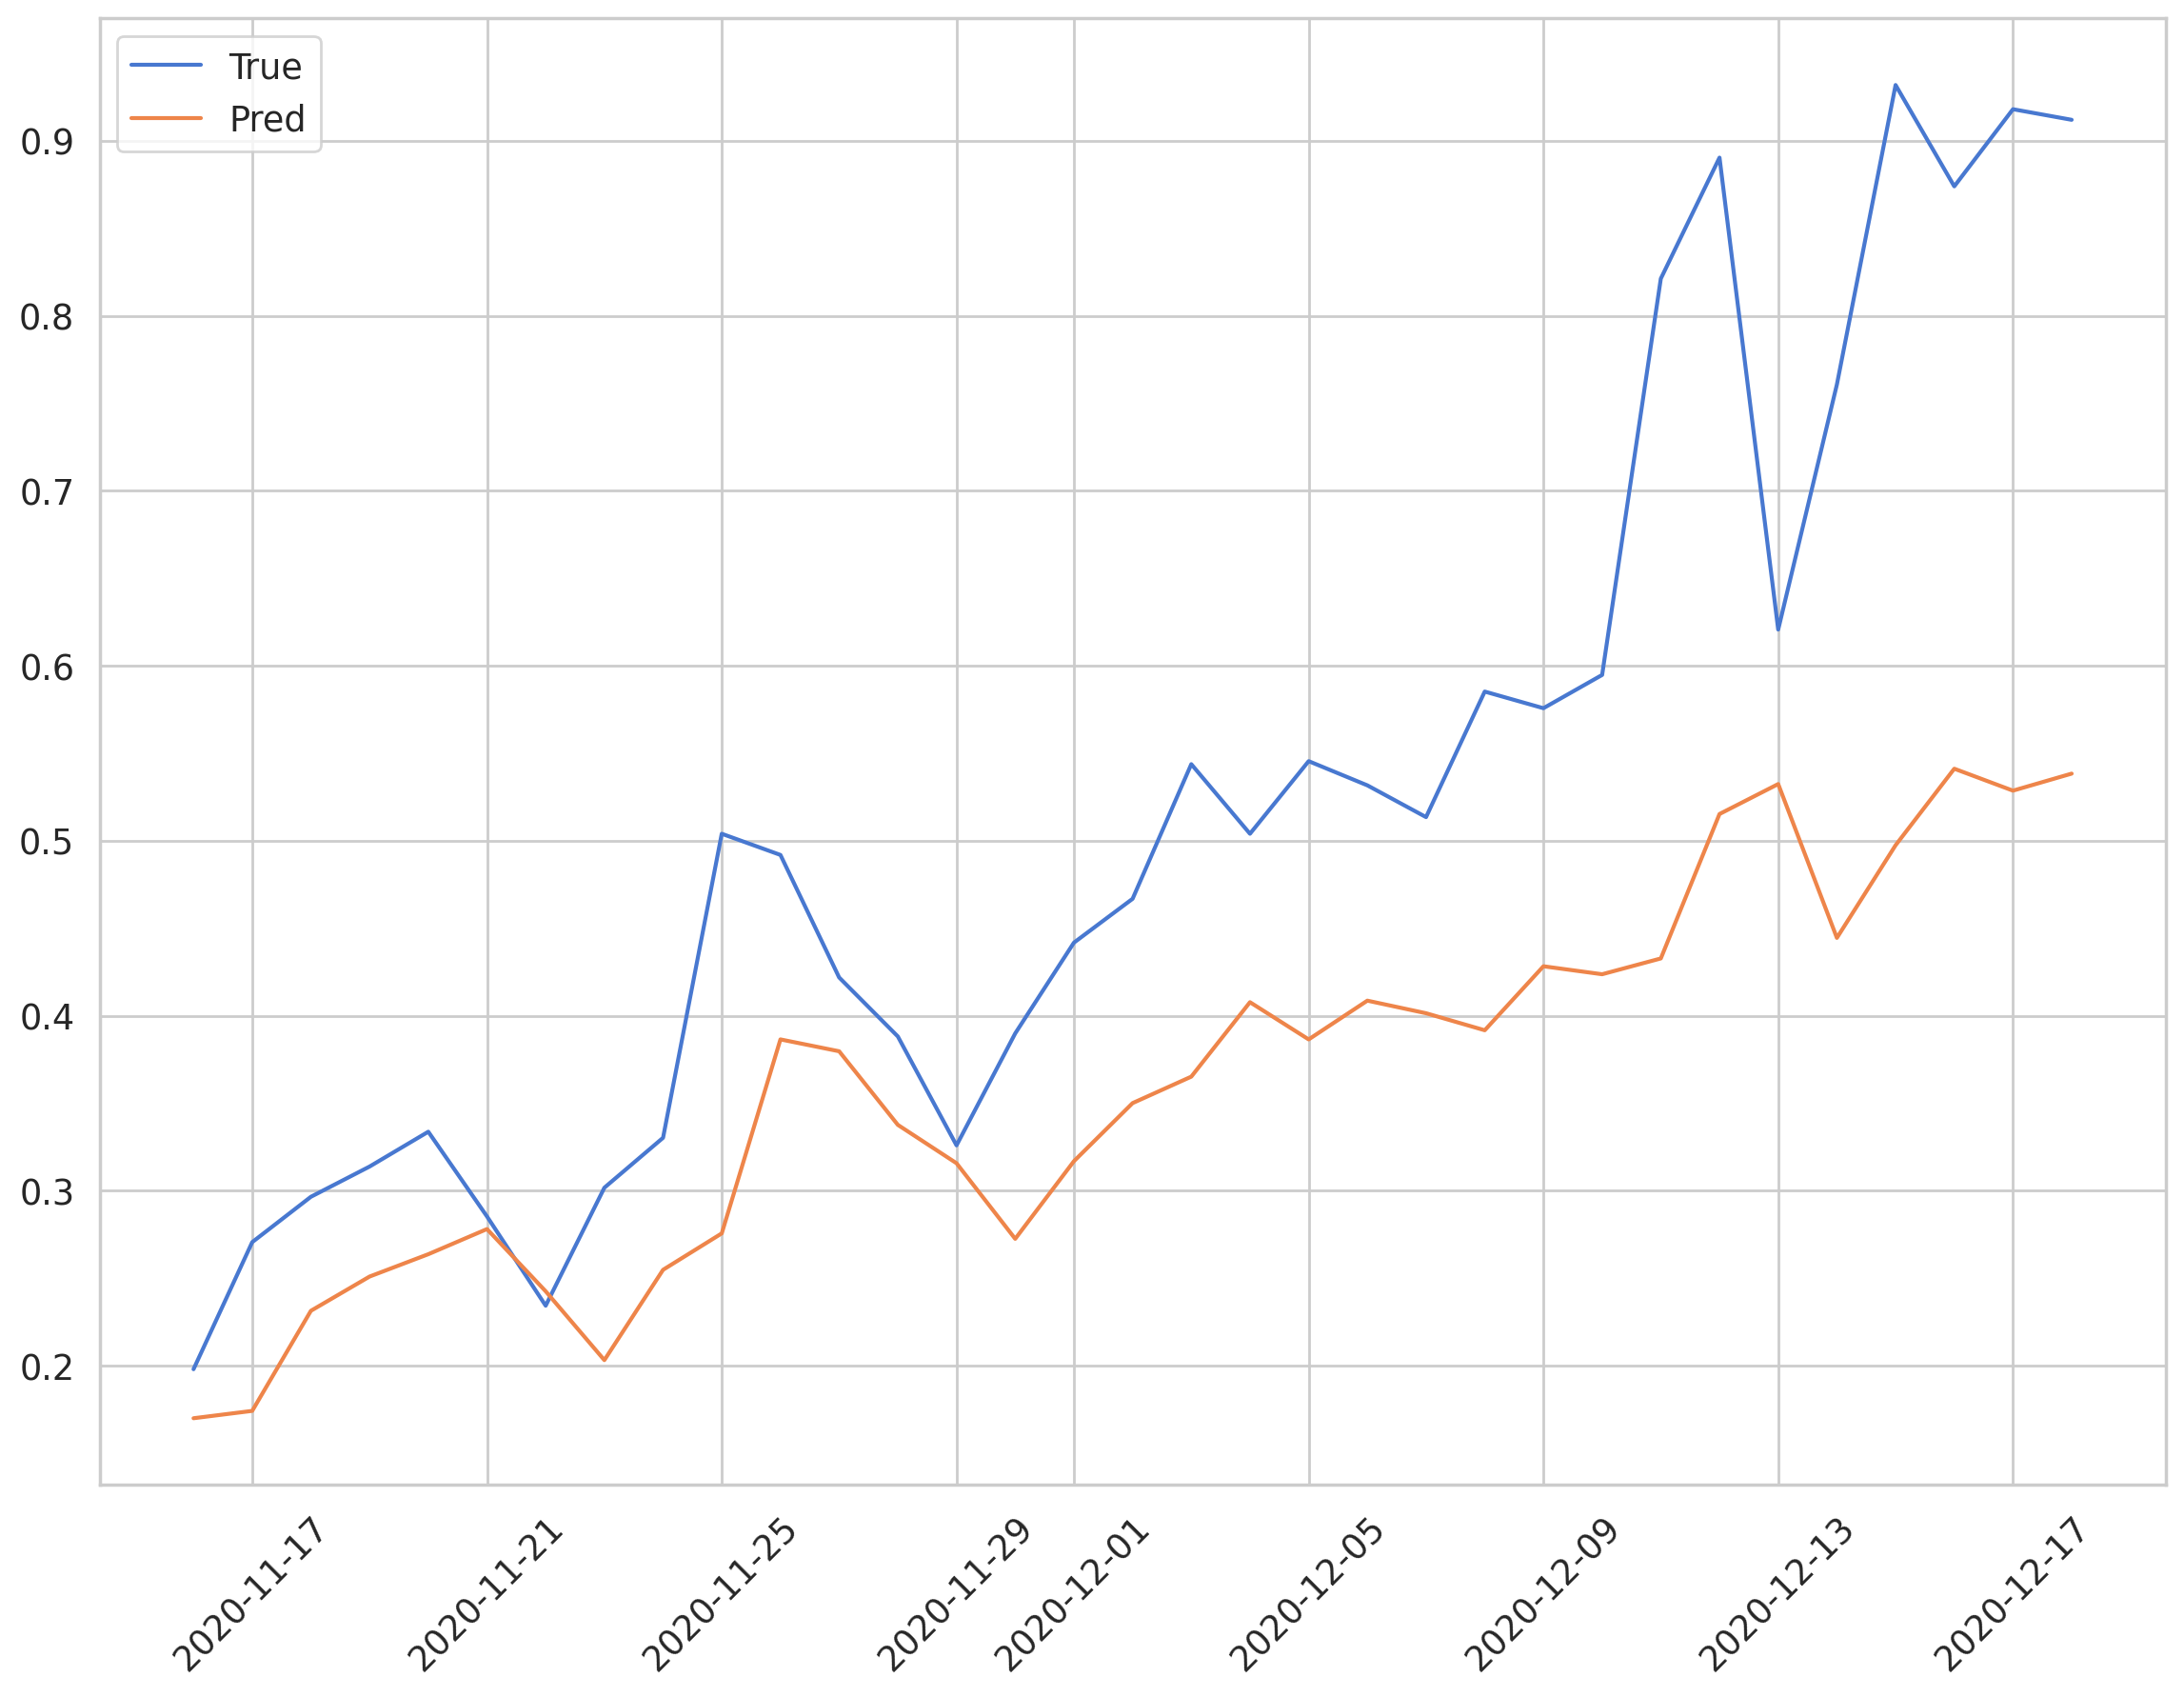

In [77]:
#역으로 적용하는 이유는?
MAX=max(preds)

plt.plot(daily_cases.index[-len(y_test):], np.array(y_test) * MAX, label='True')
plt.plot(daily_cases.index[-len(preds):], np.array(preds) * MAX, label='Pred')
plt.xticks(rotation=45)
plt.legend()

***결과 예제***

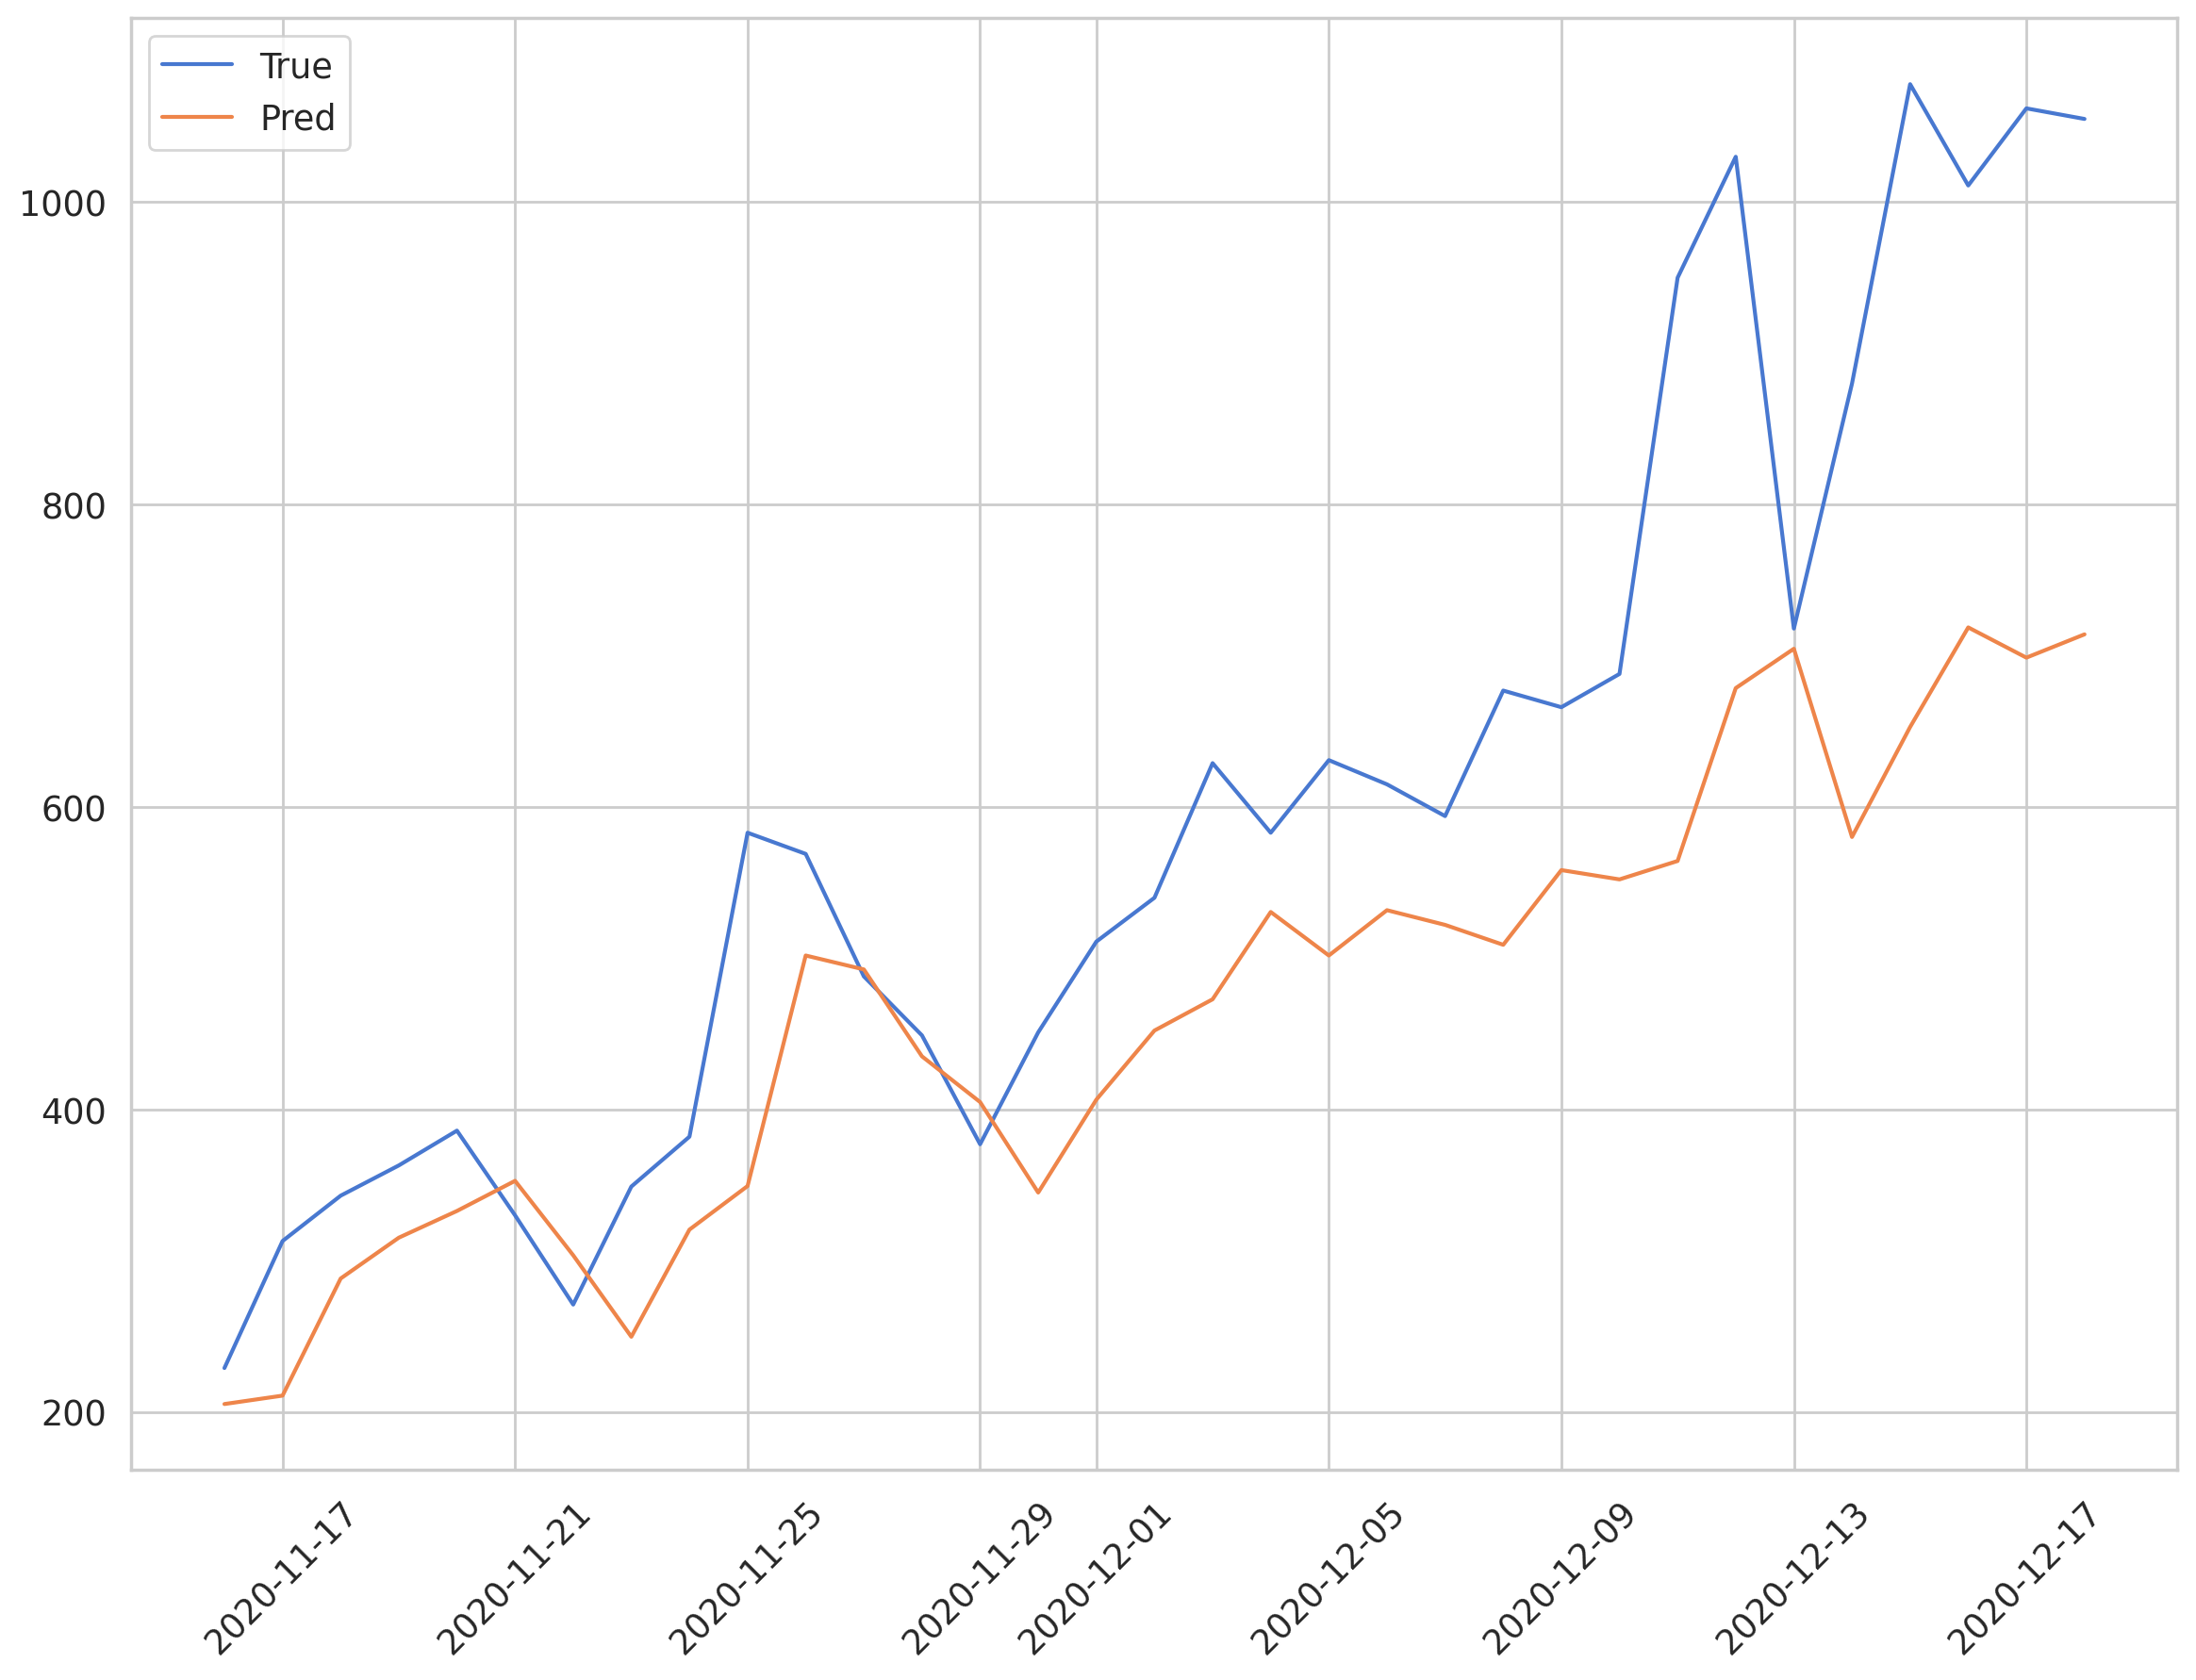